# Optimization Methods

지금가지는 경사 하강법을 이용해 파라미터 값을 최적화했다. 여기서는 더 나은 최적화 기법을 다룰 것이다. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from opt_utils import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## 1 - Gradient Descent

모든 훈련 샘플 $m$에 대한 기울기에 대한 기울기를 가지고 훈련을 진행하는 것을 경사 하강법, 또는 배치 경사 하강법이라고 한다.

In [2]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    for i in parameters.keys():
        parameters[i] -= learning_rate * grads['d' + i]
    return parameters

경사 하강법의 한 변종은 확률적 경사 하강법(Stochastic Gradient Descent; SGD)이다. 이것은 하나의 샘플에 대해 경사 하강법을 적용한 것으로서, 미니 배치의 크기가 1인 경사 하강법과 같다. 훈련셋의 크기가 클 경우 SGD는 빠르지만 최저점을 향해 진동할 것이다. SGD는 샘플을 하나씩 이용하기 때문에 백터 계산의 장점을 살리지 못한다.반면 미니배치 경사 하강법은 배치 경사 하강법과 확률적 경사 하강법의 중간 방법으로서, 중간 정도 크기의 샘플에 대해 경사 하강법을 적용한다. 일반적으로 미니배치 경사 하강법은, 특히 훈련셋의 크기가 클 경우, 배치 경사 하강법이나 SGD보다 성능이 뛰어나다.


## 2 - Mini-Batch Gradient descent

미니배치 경사하강법은 1. 샘플 뒤섞기 2. 샘플 나누기의 순서로 구현한다. 훈련셋의 전체 샘플 개수가 미니배치의 크기로 나누어떨어지지 않을 경우, 마지막 미니배치의 크기는 다른 미니배치보다 작아야 한다.

In [3]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    
    m = X.shape[1]      
    mini_batches = []
    
    # 1단계: 뒤섞기
    permutation = np.random.permutation(m)
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]
    
    # 2단계: 나누기
    num_complete_minibatches = m // mini_batch_size
    for i in range(num_complete_minibatches):
        mini_batch_X = shuffled_X[:, i*mini_batch_size:(i+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, i*mini_batch_size:(i+1)*mini_batch_size]
        mini_batches.append((mini_batch_X, mini_batch_Y))
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size:]
        mini_batches.append((mini_batch_X, mini_batch_Y))
    
    return mini_batches

## 3 - Momentum

모멘텀을 이용하면 훈련 과정에서 생기는 진폭을 줄일 수 있다. 그레디언트의 지수 이동 평균 값을 이용해서 과거 그레디언트를 반영하는 값을 파라미터 업데이트에 사용하는 것이다. 이때 과거 그레디언트 값을 저장하는 $v$는 언덕을 내려가는 "속도"로 이해할 수 있다.


$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}$$


In [4]:
def initialize_velocity(parameters):
    v = {}
    for i in parameters.keys():
        v['d' + i] = np.zeros(parameters[i].shape)
    return v

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    
    for i in parameters.keys():
        v['d'+i] = beta*v['d'+i] + (1-beta)*grads['d'+i]
        parameters[i] -= learning_rate*v['d'+i]
    return parameters, v

- 속도 v는 0으로 초기화해주었다. 그러므로 처음에는 훈련의 보폭이 크지 않다. (편향을 보정해줄 수도 있다)
- 만약 $\beta = 0$으로 놓으면, 이는 표준적인 경사 하강법과 같다. 

- $\beta$ 값이 클수록 과거의 그레디언트를 더 많이 반영한다. 
- 일반적으로 $\beta$ 값은 0.8~0.999의 값을 선택한다. $\beta = 0.9$는 합리적인 초기값이다.

## 4 - Adam

아담은 RMSProp과 Momentum을 합쳐놓은 것이다.

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_1)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$

- 업데이트가 진행될수록 편향을 보정할 필요가 적어지는데, 이것이 t에 의해 반영된다.
- $\varepsilon$는 분모가 0이 되는 걸 방지하기 위해 도입된 작은 값이다.


In [5]:
def initialize_adam(parameters) :
    
    v = {}
    s = {}
    for i in parameters.keys():
        v['d'+i] = np.zeros_like(parameters[i])
        s['d'+i] = np.zeros_like(parameters[i])
    return v, s

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    v_corrected = {}
    s_corrected = {}
    for i in parameters.keys():
        
        v['d'+i] = beta1*v['d'+i] + (1-beta1)*grads['d'+i]
        v_corrected['d'+i] = v['d'+i] / (1-beta1**t)
        
        s['d'+i] = beta2*s['d'+i] + (1-beta2)*(grads['d'+i]**2)
        s_corrected['d'+i] = s['d'+i] / (1-beta2**t)
        
        parameters[i] -= learning_rate * v_corrected['d'+i] / (np.sqrt(s_corrected['d'+i])+epsilon)
    
    return parameters, v, s

이제 최적화 기법들을 시험해보자.

## 5 - Model with different optimization algorithms

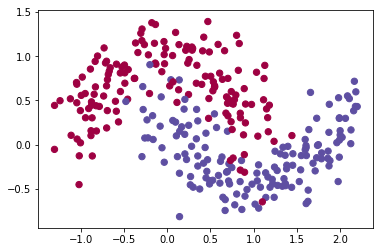

In [6]:
train_X, train_Y = load_dataset()

3층 신경망에 대해 다음을 시험해볼 것이다.
- Mini-batch **Gradient Descent**
- Mini-batch **Momentum**
- Mini-batch **Adam**

In [7]:
# 비교에 사용할 3층 신경망 모델
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        minibatches = random_mini_batches(X, Y, mini_batch_size)

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost
            cost = compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 10 == 0:
            costs.append(cost)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

### 5.1 - Mini-batch Gradient descent

Cost after epoch 0: 0.706583
Cost after epoch 1000: 0.667547
Cost after epoch 2000: 0.619194
Cost after epoch 3000: 0.621264
Cost after epoch 4000: 0.541696
Cost after epoch 5000: 0.536323
Cost after epoch 6000: 0.536890
Cost after epoch 7000: 0.556729
Cost after epoch 8000: 0.459538
Cost after epoch 9000: 0.557051


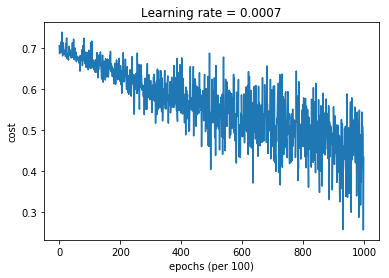

Accuracy: 0.7966666666666666


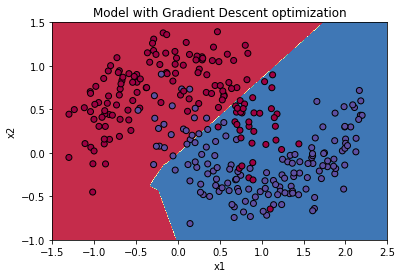

In [8]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### 5.2 - Mini-batch gradient descent with momentum

Cost after epoch 0: 0.706614
Cost after epoch 1000: 0.667610
Cost after epoch 2000: 0.619337
Cost after epoch 3000: 0.621371
Cost after epoch 4000: 0.541800
Cost after epoch 5000: 0.536441
Cost after epoch 6000: 0.537024
Cost after epoch 7000: 0.556854
Cost after epoch 8000: 0.460130
Cost after epoch 9000: 0.557142


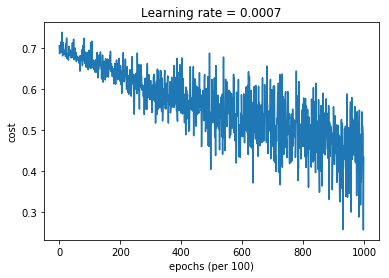

Accuracy: 0.7966666666666666


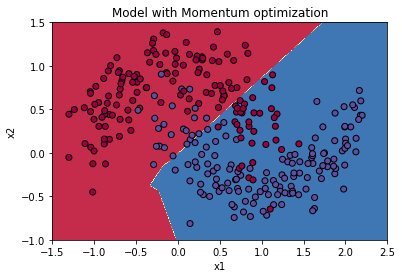

In [9]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

지금의 예시가 비교적 단순하기 때문에 모멘텀을 사용한 효과가 작다. 하지만 복잡한 문제에서는 차이를 볼 수 있을 것이다.

### 5.3 - Mini-batch with Adam mode

Cost after epoch 0: 0.705124
Cost after epoch 1000: 0.145883
Cost after epoch 2000: 0.096292
Cost after epoch 3000: 0.104643
Cost after epoch 4000: 0.067480
Cost after epoch 5000: 0.171954
Cost after epoch 6000: 0.171094
Cost after epoch 7000: 0.115736
Cost after epoch 8000: 0.119551
Cost after epoch 9000: 0.137406


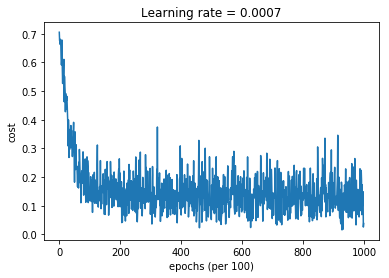

Accuracy: 0.94


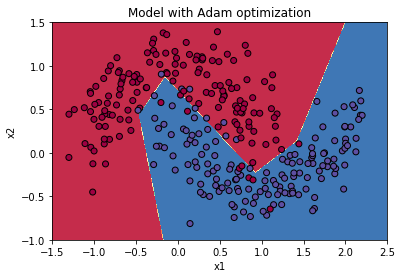

In [10]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### 5.4 - Summary

아담은 미니배치 경사 하강법이나 모멘텀보다 분명이 성능이 좋게 나왔다. 만약 학습을 오래 시키면 다른 방법들도 좋은 결과를 낼 것이다. 하지만 아담은 훨씬 빠르게 수렴하는 것을 볼 수 있다.

아담의 장점은 다음과 같다.

- 상대적으로 요구되는 메모리가 작다는 점. (경사 하강법이나 모멘텀보다는 많이 들긴 하지만)
- 하이퍼 파라미터 튜닝을 거의 하지 않고도 잘 작동한다는 점. ($\alpha$ 제외)

**References**:

- Adam paper: https://arxiv.org/pdf/1412.6980.pdf